In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

In [5]:
#load data
df = pd.read_csv('concrete_data.csv')  # or 'concrete.csv' depending on file
df.columns = [c.strip() for c in df.columns]  # clean column names
print(df.shape)
df.head()

(1030, 9)


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [6]:
#EDA
print(df.info())
print(df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   cement                         1030 non-null   float64
 1   blast_furnace_slag             1030 non-null   float64
 2   fly_ash                        1030 non-null   float64
 3   water                          1030 non-null   float64
 4   superplasticizer               1030 non-null   float64
 5   coarse_aggregate               1030 non-null   float64
 6   fine_aggregate                 1030 non-null   float64
 7   age                            1030 non-null   int64  
 8   concrete_compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None
                                count        mean         std     min  \
cement                         1030.0  281.167864  104.506364  102.00   
blast_furnace_slag             1

In [7]:
# Check for missing values
print('Missing values per column:')
print(df.isnull().sum())

Missing values per column:
cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
concrete_compressive_strength    0
dtype: int64


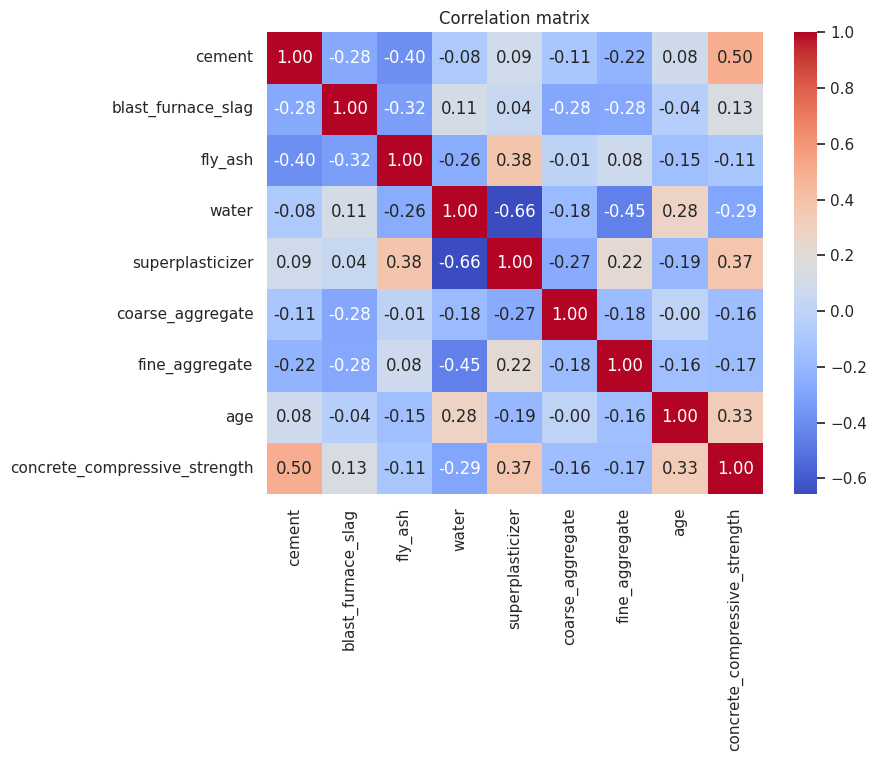

In [8]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [9]:
# Feature / target split
X = df.drop(columns=['concrete_compressive_strength'] , errors='ignore')
# try common alternative names:
if X.shape[1] != df.shape[1] - 1:
    # attempt by last column as target
    X = df.iloc[:,:-1]
y = df.iloc[:,-1]
print('X shape, y shape:', X.shape, y.shape)

# === 5) Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X shape, y shape: (1030, 8) (1030,)


In [11]:
# Model 1: Baseline Linear Regression
pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

def print_metrics(y_true, y_pred, label='Model'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{label} --> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}')

print_metrics(y_test, y_pred_lr, 'LinearRegression')

LinearRegression --> RMSE: 9.796, MAE: 7.746, R2: 0.628


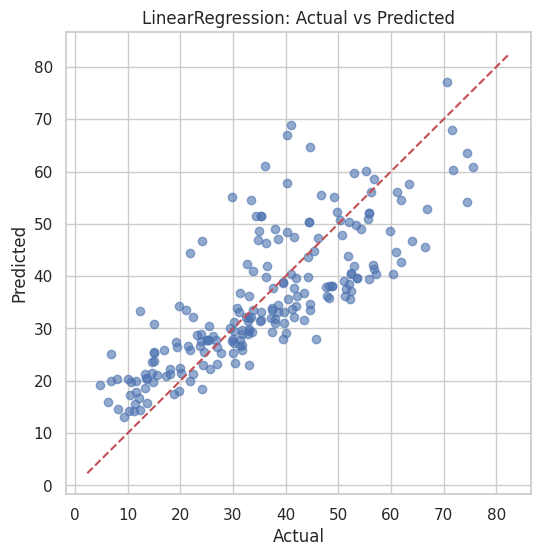

In [12]:
# Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LinearRegression: Actual vs Predicted')
plt.show()

In [13]:
# Model 2: Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print_metrics(y_test, y_pred_rf, 'RandomForest')

RandomForest --> RMSE: 5.462, MAE: 3.767, R2: 0.884


Top features:
 age                   0.334236
cement                0.325039
water                 0.126721
blast_furnace_slag    0.077017
superplasticizer      0.056330
fine_aggregate        0.035023
coarse_aggregate      0.027656
fly_ash               0.017978
dtype: float64


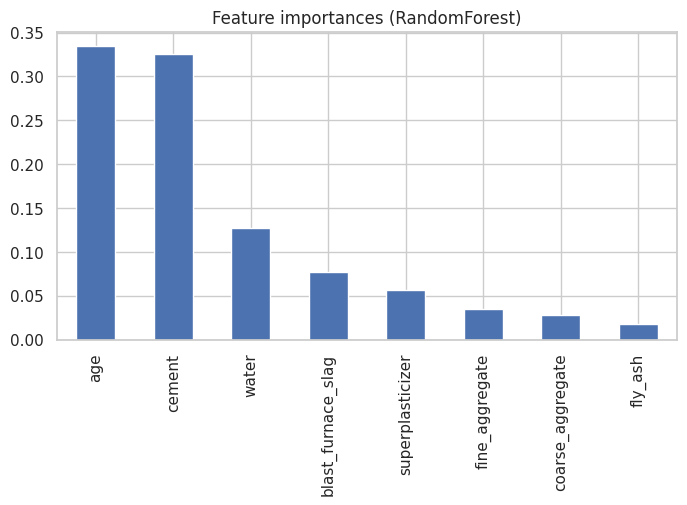

In [14]:
# Feature importances (if columns exist)
if isinstance(X, pd.DataFrame):
    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print('Top features:\n', importances.head(10))
    plt.figure(figsize=(8,4))
    importances.plot(kind='bar')
    plt.title('Feature importances (RandomForest)')
    plt.show()

In [15]:
# K fold cross validation with K=3
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
print('RF CV RMSE (3-fold):', -cv_scores.mean(), '±', cv_scores.std())

RF CV RMSE (3-fold): 5.282171256003726 ± 0.2897490539239087


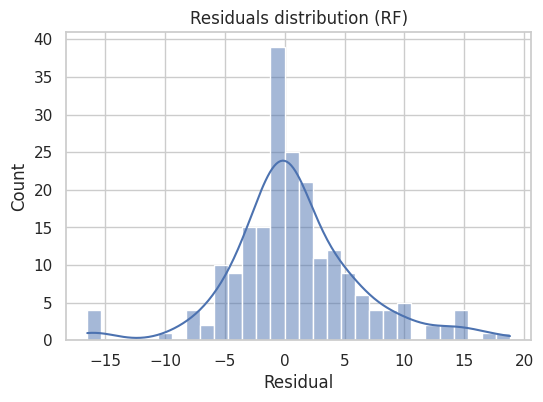

In [16]:
# Residual plot
residuals = y_test - y_pred_rf
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals distribution (RF)')
plt.xlabel('Residual')
plt.show()

In [17]:
# Save model
joblib.dump(rf, 'rf_concrete_model.joblib')
print('Saved model to rf_concrete_model.joblib')

Saved model to rf_concrete_model.joblib
